# Suspension Analysis

There were many goals with this analysis. The first was just to get a grasp on the proportion of students who were on academic probation or suspension every semester as a whole. This same analysis would be akin to ascertaining the proportion of clients that are 30 days delinquent on payments, then 60, then 90, etc. Then I wanted to see the proportion of that total that were suspension and the proportion that were probation. I also wanted to know how many of the students who were on suspension or probation reenrolled for the next semester. Finally, I looked at the GPAs students earned who were on suspension or probation in relation to the number of credit hours they took. 

Surprising findings were that students actually averaged a lower GPA when on probation than on suspension. When examining GPAs in relation to credit hours, the students on probation overwhelmingly took more credit hours, literally inverting the proportion who were more than or equal to six credits but less than nine, more than or equal to nine credits but less than eleven, and twelve credits or more. One of the primary reasons for this is that, with few exceptions, students on academic suspension are *required* to take no more than six credits, they have to be in person, and they have to be courses they previously failed. Probabtion students are still allowed to take twelve credits, a full load. Consequently, they will often take exactly twelve credits, which does not help. 

The result of this analysis was a revamping of the probation and suspension policies at the college. Advisors were given less leeway for when they could break the suspension enrollment rules (enrolling in more than six credits), and they were presented with the analysis of probation students. A consensus was drawn that probation students should be strongly encouraged by all advisors to take less than 12 credits. More recent discussions with the Director of Adivising for SP24 is moving to limiting probation students to nine credits, since the number one goal of the college is to help students finish what they start. Allowing probation students to continue to enroll in full time credits empirically hurts their advancement towards their goals. 

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
%%html
<style>
table {float:left}
</style>

In [3]:
# Load in data
sus_df = pd.read_csv('Holds 202110 - 202310 FA, SP, SU.csv')

# Enrollment numbers are 20th-Day Numbers and EOT for Summer
enroll_df = pd.read_csv('202110 - 202280 FA, SP, SU HC 20th-D.csv', encoding = 'cp1252')

gpa_df = (pd.read_csv('GPAs 202110 - 202280 FA, SP, SU.csv')
           .rename(columns = {'StudentID':'id',
                              'GPATrm':'term',
                              'trmGPA':'term_gpa',
                              'trmAttmpt':'term_att_crhr'})
         )

# Standardize columns
sus_df.columns = [i.lower() for i in sus_df.columns]
enroll_df.columns = [i.lower() for i in enroll_df.columns]
gpa_df.columns = [i.lower() for i in gpa_df.columns]

# Pair down dataframe to only necessary columns
sus_df = (sus_df[['stdtid', 'sprcr', 'sucr', 'facr', 'prob_sus_trm', 'sts', 'tgpa', 
                 'prob_susp_typ', 'prob_susp_res', 'lgpa']]
                 .rename(columns = {'stdtid':'id', 'prob_sus_trm':'term'})
         )

enroll_df = enroll_df[['id', 'term', 'age', 'totcr', 'stype', 'resd_desc', 'degree', 'majr_desc1', 
                       'gender', 'mrtl', 'race_desc', 'ethn_desc', 'cnty_desc1']]


gpa_df = gpa_df[['id', 'term', 'term_att_crhr', 'term_gpa']]

# Analysis

The first part of the analysis is going to be getting a broad idea of how many students were on academic suspension or probation.

In [4]:
# Isolate proportion of students who are on suspension, probation, and sus+prob for every semester
d = {}

terms = [202110, 202160, 202180, 202210, 202260, 202280]

for i in terms:
    temp_enroll = enroll_df[enroll_df['term'] == i]
    temp_sus = sus_df[sus_df['term'] == i]
    d[i] = [len(temp_enroll), len(temp_sus),
            round((len(temp_sus) / len(temp_enroll)) * 100, 3), 
            round((len(temp_sus[temp_sus['sts'] == 'P'])/len(temp_sus)) * 100, 3), 
            round((len(temp_sus[temp_sus['sts'] == 'S'])/len(temp_sus)) * 100, 3)]

In [5]:
(pd.DataFrame.from_dict(d).T
   .reset_index()
   .rename(columns = {'index':'Semester',
                     0:'20th_D_HC',
                     1:'P_and_S_HC',
                     2:'Prop_On_Sus/Prob', 
                     3:'Prop_of_Tot_On_P',
                     4:'Prop_of_Tot_On_S'})
)

,Semester,20th_D_HC,P_and_S_HC,Prop_On_Sus/Prob,Prop_of_Tot_On_P,Prop_of_Tot_On_S
0,202110,6532.0,712.0,10.900,61.938,38.062
1,202160,2926.0,208.0,7.109,57.692,42.308
2,202180,7045.0,898.0,12.747,70.601,29.399
3,202210,6199.0,634.0,10.227,55.363,44.637
4,202260,2831.0,245.0,8.654,54.286,45.714
5,202280,6727.0,868.0,12.903,70.622,29.378


## Second Phase

Now I am turning my attention to if the students reenrolled and if they did, how long before they came back.

In [6]:
# Merge the suspension dataframe with the enrollment dataframe

sus_df['enrolled'] = 'sus_prob'

sub_sus_df = sus_df[['id', 'term', 'sts', 'enrolled']]

merged_df = enroll_df.merge(sub_sus_df, how = 'left', on = ['id', 'term'])

merged_df = merged_df.merge(gpa_df, how = 'left', on = ['id', 'term'])

merged_df['enrolled'], merged_df['sts'] = merged_df['enrolled'].fillna('no'), merged_df['sts'].fillna('no S/P')

In [7]:
terms = [202110, 202180, 202210, 202280]
terms2 = [202180, 202210, 202280, 202310]

enrollments = {t: 0 for t in terms2}
term_ids = []

for i in range(0, 4):
    mask = merged_df['term'] == terms[i]
    mask2 = merged_df['sts'] == 'P'
    temp_ps = merged_df[mask & mask2]
    p_s_ls = list(temp_ps['id'])

    temp_enr = merged_df[merged_df['term'] == terms2[i]]
    for j in list(temp_enr['id']):
        if j in p_s_ls:
            enrollments[terms2[i]] += 1
            term_ids.append({terms[i]: j})
            
data = [enrollments[t] for t in terms2]

(pd.DataFrame(data, columns=['Sus_ReEnroll'], index=terms2)
   .reset_index()
   .rename(columns={'index': 'Sem'})
)

,Sem,Sus_ReEnroll
0,202180,126
1,202210,231
2,202280,108
3,202310,270


In [8]:
# Set up dataframe that captures the ids of only the suspension students by term they enrolled
# after suspension
gpa_ids = pd.DataFrame.from_dict(term_ids)

# Iterate over columns of DataFrame
sus_ids = []

for i in range(0, 4):
    # Create DataFrame with non-null values for column i
    temp = pd.DataFrame({'id': gpa_ids.iloc[:,i].dropna(), 'term': terms2[i]})
    sus_ids.append(temp)

# Concatenate DataFrames into a single DataFrame
sus_ids = pd.concat(sus_ids)

In [9]:
# Create dataframe of suspension ids from each term merged with their gpas and num of crhrs taken
eot_sus = sus_ids.merge(gpa_df, how = 'left', on = ['id', 'term'])

# Create a new column to hold groupings of credit hours taken
crhr_spread = []
for i in eot_sus['term_att_crhr']:
    if i < 6:
        crhr_spread.append('<HT')
    elif i >=6 and i < 9:
        crhr_spread.append('PT')
    elif i >=9 and i < 12:
        crhr_spread.append('3/4T')
    else:
        crhr_spread.append('FT')

eot_sus['crhr_spread'] = crhr_spread

In [10]:
# Create table with average gpa for each group of credit hours

(pd.DataFrame(eot_sus.groupby(['term', 'crhr_spread'])
   .agg({'id':'count',
        'term_gpa':'mean'}))
   .reset_index()
   .pivot_table(index = 'crhr_spread', columns = 'term', values = ['id', 'term_gpa'])
)

id                       term_gpa                    
term        202180 202210 202280 202310    202180    202210    202280
crhr_spread                                                          
3/4T          27.0   54.0   23.0    NaN  1.397778  1.040185  1.150000
<HT           24.0   43.0   16.0    NaN  0.902500  1.232558  2.270625
FT            39.0   88.0   38.0  270.0  1.800000  1.892469  1.853333
PT            36.0   46.0   31.0    NaN  1.318056  1.163696  1.342903

In [11]:
# Create a table that shows the average GPA for suspension students 
# from each semester. I did it this way so as to avoid Simpson's Paradox.
# I didn't want to just average the average GPAs from the table above.

sus_tot_gpa = {}

for i in eot_sus['term']:
    temp = eot_sus[eot_sus['term'] == i]
    sus_tot_gpa[i] = temp['term_gpa'].mean()
    
(pd.DataFrame.from_dict(sus_tot_gpa, orient = 'index')
   .reset_index()
   .rename(columns = {'index':'term',
                     0:'Tot_Avg_GPA'})[:-1]
)

,term,Tot_Avg_GPA
0,202180,1.402000
1,202210,1.410670
2,202280,1.614434


In [12]:
# Create a table that shows the number of students and the percent of suspension students 
# that number represetns from each term that earned a certain GPA or higher.

t = {}

for i in eot_sus['term'].unique():
    t[i] = [len(eot_sus[(eot_sus['term'] == i) & (eot_sus['term_gpa'] >= 2.0)]), 
            round((len(eot_sus[(eot_sus['term'] == i) & (eot_sus['term_gpa'] >= 2.0)])/
                   len(eot_sus[eot_sus['term'] == i]))*100, 3)]

(pd.DataFrame.from_dict(t, orient = 'index')
   .reset_index()
   .rename(columns = {'index':'term',
                     0:'hc',
                     1:'% rep'})
)

,term,hc,% rep
0,202180,54,42.857
1,202210,97,41.991
2,202280,51,47.222
3,202310,0,0.000


### Create Density Plots For Probation or Suspension Students GPAs

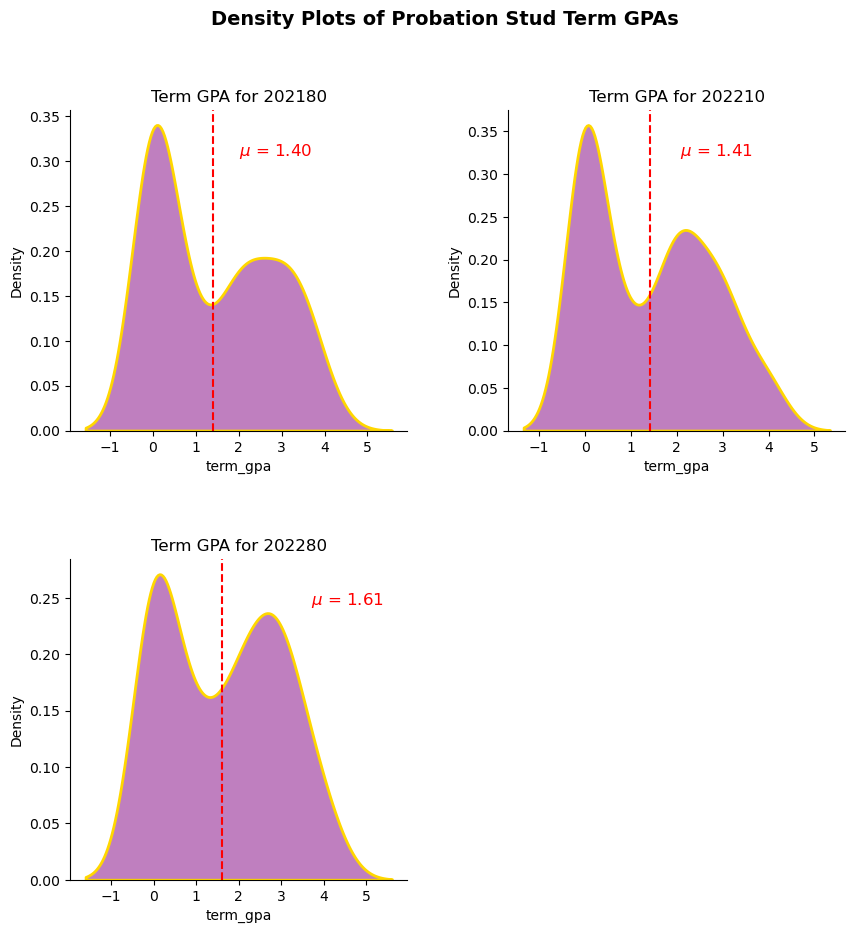

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(10, 10))

# Define the terms
terms = [202180, 202210, 202280]

# Create a loop to plot the density plots for each term
for i, term in enumerate(terms):
    # Filter the dataframe for the current term
    term_df = eot_sus[eot_sus['term'] == term]
    
    # Calculate the mean GPA for the current term
    term_mean = term_df['term_gpa'].mean()
    
    # Create a subplot for the current term
    plt.subplot(2, 2, i+1)
    
    # Create the density plot
    sns.kdeplot(data=term_df, x='term_gpa', fill=True, color='purple', 
                alpha=0.5, linewidth=2, edgecolor='gold')
    
    # Add a vertical dashed line for the mean GPA
    plt.axvline(x=term_mean, color='red', linestyle='--')
    
    # Add a text label for the mean GPA
    plt.text(term_mean - 0.9, 0.9, r'$\mu$ = {:.2f}'.format(term_mean), 
             transform=plt.gca().transAxes, color='red', fontsize=12, 
             verticalalignment='top')
    # Set the title for the current subplot
    plt.title("Term GPA for {}".format(term))
    
    # Remove the top and right spines
    sns.despine(top=True, right=True)
    
# Adjust the spacing between subplots
plt.suptitle("Density Plots of Probation Stud Term GPAs\n", fontsize = 14, fontweight = 'bold')
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Show the figure
plt.show()

### Breakdown Of Credit Hours Probation Students Who Earn Above 2.0 GPA Are Enrolled In

In [14]:
# The Director wanted a breakdown of how many credit hours these students were 
# taking who were achieving the various GPA thresholds. The function
# below creates the table that communicates that for each individual
# semester

def above_threshold_gpa(df, term, gpa_threshold):
    """
    Filters a DataFrame to students from a specific term who have a GPA above a certain threshold,
    groups by credit hour spread, counts the students, calculates the representation percentage,
    and formats the output table.

    Parameters:
    df (pd.DataFrame): DataFrame with suspension students who enrolled for the following semester.
    term (int): The term to filter students by.
    gpa_threshold (float): The GPA threshold to filter the DataFrame by.
    
    Returns:
    pd.DataFrame: Formatted DataFrame with term, credit hour spread, headcount (HC), and percentage 
    representation.
    
    """
    # Using method chaining for efficiency and readability
    return (df[(df['term'] == term) & (df['term_gpa'] >= gpa_threshold)]
            .groupby('crhr_spread')
            .agg(id=('id', 'count'))
            .reset_index()
            .assign(**{'% rep': lambda x: x['id'] / x['id'].sum() * 100, 'term': term})
            .rename(columns={'id': 'HC'})
            .loc[:, ['term', 'crhr_spread', 'HC', '% rep']])


In [15]:
gpa_table = []

for i in eot_sus['term'].unique():
    gpa_table.append(above_threshold_gpa(eot_sus, i, 3.0))

(pd.concat(gpa_table)
   .pivot_table(index = 'crhr_spread', columns = 'term', values = ['HC', '% rep'])
)

% rep                   HC              
term            202180 202210 202280 202180 202210 202280
crhr_spread                                              
3/4T         18.518519   12.5   12.0      5      5      3
<HT          22.222222   25.0   36.0      6     10      9
FT           33.333333   42.5   28.0      9     17      7
PT           25.925926   20.0   24.0      7      8      6